In [1]:
# fix poisoon distribution rvs so that it preserves ranks when a seed is specified
%pylab inline
from astropy.utils.misc import NumpyRNGContext
from halotools.empirical_models.occupation_models.occupation_model_template import OccupationComponent
from scipy.special import pdtrik

def _poisson_distribution_corrected(self, first_occupation_moment, seed=None, **kwargs):
    with NumpyRNGContext(seed):
        result = np.ceil(pdtrik(np.random.rand(*first_occupation_moment.shape),
                                first_occupation_moment)).astype(np.int)
    if 'table' in kwargs:
        kwargs['table']['halo_num_'+self.gal_type] = result
    return result

OccupationComponent._poisson_distribution = _poisson_distribution_corrected

Populating the interactive namespace from numpy and matplotlib


In [2]:
# add PreservingNgalHeavisideAssembias which preserves N_gal when applying assembly bias

import numpy as np
from astropy.utils.misc import NumpyRNGContext
from halotools.empirical_models.assembias_models.heaviside_assembias import HeavisideAssembias
from halotools.utils.array_utils import custom_len
from halotools.custom_exceptions import HalotoolsError

class PreservingNgalHeavisideAssembias(HeavisideAssembias):
    def assembias_mc_occupation(self, seed=None, **kwargs):
        first_occupation_moment_orig = self.mean_occupation_orig(**kwargs)
        first_occupation_moment = self.mean_occupation(**kwargs)
        if self._upper_occupation_bound == 1:
            with NumpyRNGContext(seed):
                score = np.random.rand(custom_len(first_occupation_moment_orig))
            total = np.count_nonzero(first_occupation_moment_orig > score)
            result = np.where(first_occupation_moment > score, 1, 0)
            diff = result.sum() - total
            if diff < 0:
                x = (first_occupation_moment / score)
                result.fill(0)
                result[x.argsort()[-total:]] = 1
            elif diff > 0:
                x = (1.0-first_occupation_moment) / (1.0-score)
                result.fill(0)
                result[x.argsort()[:total]] = 1
        elif self._upper_occupation_bound == float("inf"):
            total = self._poisson_distribution(first_occupation_moment_orig.sum(), seed=seed)
            if seed is not None:
                seed += 1
            with NumpyRNGContext(seed):
                score = np.random.rand(total)
            score.sort()
            x = first_occupation_moment.cumsum() / first_occupation_moment.sum()
            result = np.ediff1d(np.insert(np.searchsorted(score, x), 0, 0))
        else:
            msg = ("\nYou have chosen to set ``_upper_occupation_bound`` to some value \n"
                "besides 1 or infinity. In such cases, you must also \n"
                "write your own ``mc_occupation`` method that overrides the method in the \n"
                "OccupationComponent super-class\n")
            raise HalotoolsError(msg)

        if 'table' in kwargs:
            kwargs['table']['halo_num_'+self.gal_type] = result
        return result

    def _decorate_baseline_method(self):
        self.mean_occupation_orig = self.mean_occupation
        self.mc_occupation = self.assembias_mc_occupation
        super(PreservingNgalHeavisideAssembias, self)._decorate_baseline_method()


In [3]:
from halotools.empirical_models import Zheng07Cens, Zheng07Sats

class PreservingNgalAssembiasZheng07Cens(Zheng07Cens, PreservingNgalHeavisideAssembias):
    def __init__(self, **kwargs):
        Zheng07Cens.__init__(self, **kwargs)
        PreservingNgalHeavisideAssembias.__init__(self,
            lower_assembias_bound=self._lower_occupation_bound,
            upper_assembias_bound=self._upper_occupation_bound,
            method_name_to_decorate='mean_occupation', **kwargs)
        
class PreservingNgalAssembiasZheng07Sats(Zheng07Sats, PreservingNgalHeavisideAssembias):
    def __init__(self, **kwargs):
        Zheng07Sats.__init__(self, **kwargs)
        PreservingNgalHeavisideAssembias.__init__(self,
            lower_assembias_bound=self._lower_occupation_bound,
            upper_assembias_bound=self._upper_occupation_bound,
            method_name_to_decorate='mean_occupation', **kwargs)

In [4]:
from halotools.empirical_models import TrivialPhaseSpace, NFWPhaseSpace
from halotools.empirical_models import HodModelFactory

class HODMock(object):
    default_model_kwargs = {
        'centrals_occupation':   PreservingNgalAssembiasZheng07Cens(prim_haloprop_key='halo_mvir', sec_haloprop_key='halo_nfw_conc'),
        'satellites_occupation': PreservingNgalAssembiasZheng07Sats(prim_haloprop_key='halo_mvir', sec_haloprop_key='halo_nfw_conc'),
        'centrals_profile': TrivialPhaseSpace(),
        'satellites_profile': NFWPhaseSpace()
    }
    
    default_model_params = {
        'alpha': 1.33738,
        'logM1': 13.98811,
        'sigma_logM': 0.5595,
        'logM0': 11.95797,
        'logMmin': 12.82356,
        'mean_occupation_centrals_assembias_param1': 0.0,
        'mean_occupation_satellites_assembias_param1': 0.0,
    }
    
    param_name_translate = {
        'sigma': 'sigma_logM',
        'Acen': 'mean_occupation_centrals_assembias_param1',
        'Asat': 'mean_occupation_satellites_assembias_param1',
        'A_cen': 'mean_occupation_centrals_assembias_param1',
        'A_sat': 'mean_occupation_satellites_assembias_param1',
    }
    
    def __init__(self, halocat, default_seed=None, default_model_params=None, **kwargs):
        self.halocat = halocat
        self.default_seed = default_seed
        self.model = HodModelFactory(**dict(self.default_model_kwargs, **kwargs))
        if default_model_params:
            self.default_model_params.update(default_model_params)

    def update_params(self, **params):
        params = {self.param_name_translate.get(k, k): v for k, v in params.items()}
        self.model.param_dict.update(dict(self.default_model_params, **params))
                
    def populate(self, seed=None, **update_params):
        seed = self.default_seed if seed is None else seed
        self.update_params(**update_params)
        try:
            self.model.mock.populate(seed=seed)
        except AttributeError:
            self.model.populate_mock(self.halocat, seed=seed)
        return self
                
    def get_ngals(self, seed=None, **update_params):
        self.populate(seed=seed, **update_params)
        return len(self.galaxy_table)
        
    @property
    def galaxy_table(self):
        return self.mock.galaxy_table
    
    @property
    def mock(self):
        if not hasattr(self.model, 'mock'):
            self.populate()
        return self.model.mock

In [5]:
from halotools.sim_manager import CachedHaloCatalog

halocat = CachedHaloCatalog(simname='bolplanck', version_name='halotools_v0p4', redshift=0, halo_finder='rockstar')

In [6]:
model = HODMock(halocat, default_seed=12345)

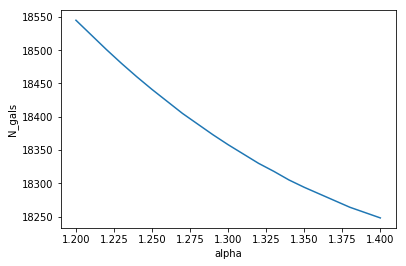

In [7]:
x = np.linspace(1.2, 1.4, 21)
output = [model.get_ngals(alpha=x_this) for x_this in x]
plt.plot(x, output);
plt.xlabel('alpha');
plt.ylabel('N_gals');

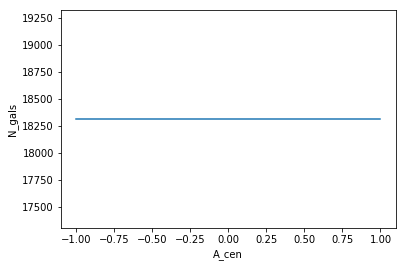

In [8]:
x = np.linspace(-1, 1, 21)
output = [model.get_ngals(A_cen=x_this) for x_this in x]
plt.plot(x, output);
plt.xlabel('A_cen');
plt.ylabel('N_gals');

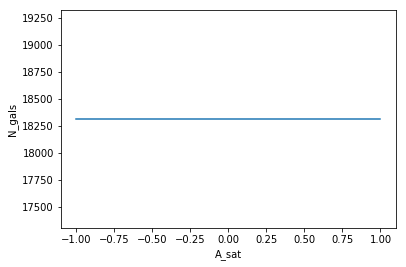

In [9]:
x = np.linspace(-1, 1, 21)
output = [model.get_ngals(A_sat=x_this) for x_this in x]
plt.plot(x, output);
plt.xlabel('A_sat');
plt.ylabel('N_gals');

In [10]:
from helpers.CorrelationFunction import projected_correlation
from halotools.mock_observables import return_xyz_formatted_array

wp_rbins = np.logspace(-1, 1.3, 11)

def calc_wp(model, rbins=wp_rbins, zmax=60.0, box_size=250.0):
    points = return_xyz_formatted_array(*(model.galaxy_table[ax] for ax in 'xyz'), 
                                        velocity=model.galaxy_table['vz'], 
                                        velocity_distortion_dimension='z',
                                        period=box_size)
    return projected_correlation(points, rbins, zmax, box_size)

In [15]:
x = np.linspace(1.2, 1.4, 21)
output = np.stack((calc_wp(model.populate(alpha=x_this)) for x_this in x))

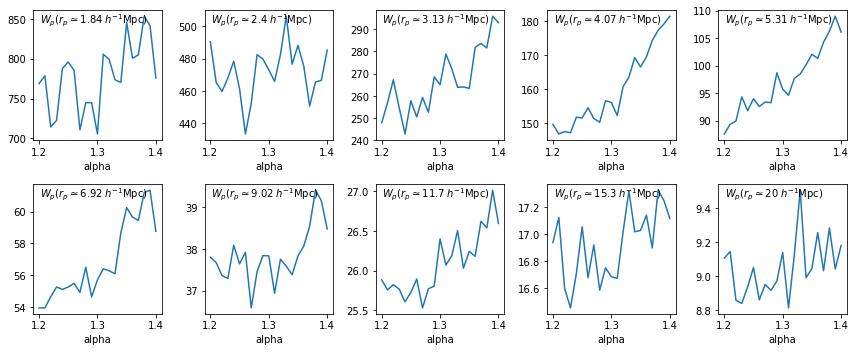

In [16]:
r = np.sqrt(wp_rbins[1:]*wp_rbins[-1])

fig, ax = plt.subplots(ncols=5, nrows=2, figsize=(12, 5), dpi=100)
for i, ax_this in enumerate(ax.flat):
    ax_this.plot(x, output[:,i]);
    ax_this.text(0.05, 0.9, r'$W_p(r_p \simeq {:.3g} \; h^{{-1}}{{\rm Mpc}})$'.format(r[i]), transform=ax_this.transAxes);
    ax_this.set_xlabel('alpha');
fig.tight_layout()

In [11]:
x = np.linspace(-1, 1, 21)
output = np.stack((calc_wp(model.populate(A_cen=x_this)) for x_this in x))

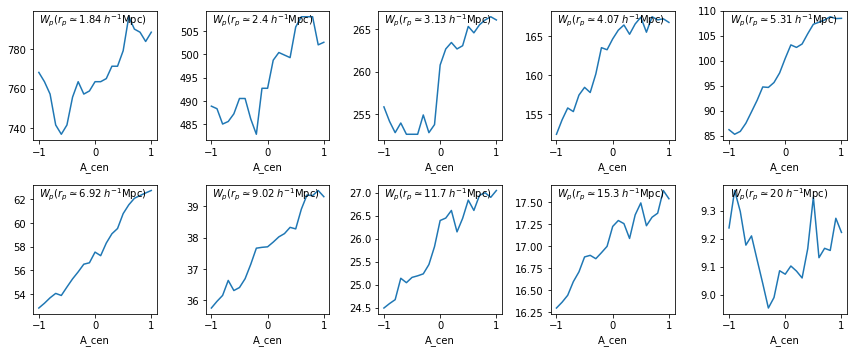

In [12]:
r = np.sqrt(wp_rbins[1:]*wp_rbins[-1])

fig, ax = plt.subplots(ncols=5, nrows=2, figsize=(12, 5), dpi=100)
for i, ax_this in enumerate(ax.flat):
    ax_this.plot(x, output[:,i]);
    ax_this.text(0.05, 0.9, r'$W_p(r_p \simeq {:.3g} \; h^{{-1}}{{\rm Mpc}})$'.format(r[i]), transform=ax_this.transAxes);
    ax_this.set_xlabel('A_cen');
fig.tight_layout()

In [13]:
x = np.linspace(-1, 1, 21)
output = np.stack((calc_wp(model.populate(A_sat=x_this)) for x_this in x))

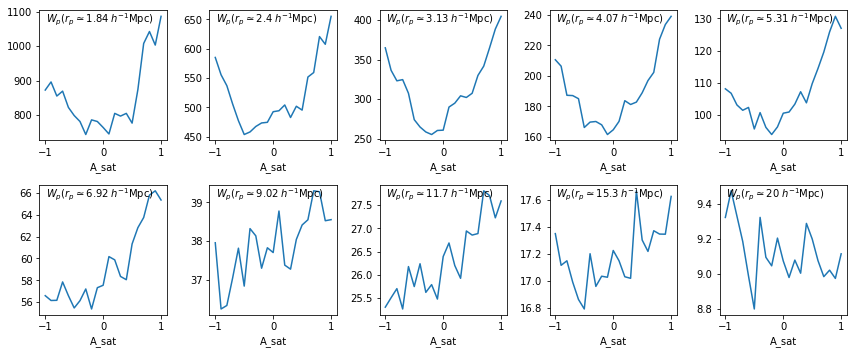

In [14]:
r = np.sqrt(wp_rbins[1:]*wp_rbins[-1])

fig, ax = plt.subplots(ncols=5, nrows=2, figsize=(12, 5), dpi=100)
for i, ax_this in enumerate(ax.flat):
    ax_this.plot(x, output[:,i]);
    ax_this.text(0.05, 0.9, r'$W_p(r_p \simeq {:.3g} \; h^{{-1}}{{\rm Mpc}})$'.format(r[i]), transform=ax_this.transAxes);
    ax_this.set_xlabel('A_sat');
fig.tight_layout()